In [1]:
import matplotlib.pyplot as plt
import matplotlib
from astropy.table import Table
import os
import astropy.units as u
import numpy as np
import pandas as pd
from scipy import interpolate


In [2]:
SIM = 'mb.69002'
TRAJ = 'p300_a800_r600'

In [3]:
SIM_PATH = '/home/michele/sim/MySimulations/ng/{}_{}/out/'.format(SIM, TRAJ)

In [4]:
tbl_ssam = Table.read('/home/michele/sim/analysis/ssam/m{}p200/maps_data_v_w10_r200_n30.fits'.format(SIM[3:5], TRAJ[1:4]))

In [5]:
tbl_ssam.info()

<Table length=563>
    name     dtype  shape n_bad
----------- ------- ----- -----
       time float64           0
   lambda_r float64         120
      ellip float64         120
      theta float64         120
  r_eff_kpc float64         120
r_eff_kpc3d float64         120
          n float64         120
         Lx float64         120
         Ly float64         120
         Lz float64         120
      mag_v float64         120
lambda_prof float64 (30,)  3600


In [6]:
lambda_prof = tbl_ssam['lambda_prof']
tbl_ssam.remove_column('lambda_prof')

In [7]:
tbl_ssam.info()

<Table length=563>
    name     dtype  n_bad
----------- ------- -----
       time float64     0
   lambda_r float64   120
      ellip float64   120
      theta float64   120
  r_eff_kpc float64   120
r_eff_kpc3d float64   120
          n float64   120
         Lx float64   120
         Ly float64   120
         Lz float64   120
      mag_v float64   120


In [8]:
from simulation.parsers.parse_trace import parse_trace
trace = parse_trace(os.path.join(SIM_PATH, 'trace.txt'))

# Sync trace time and snapshot time
# Right is true to keep the last index otherwise it will result in NaN
locations = np.digitize(tbl_ssam['time'], trace.t, right=True)
print(locations.shape)

for f in ['r', 'v', 'a', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'ax', 'ay', 'az']:
    tbl_ssam[f] = trace[f].loc[locations].values

other_tbl = Table.read('/home/michele/sim/analysis/ng_ana/data_pd/{}_{}.fits'.format(SIM, TRAJ))
for f in ['mass_star', 'sigma_gas', 'sigma_star', 'sfr', 'metals_star']:
    tbl_ssam[f] = other_tbl[f]


(563,)


In [9]:
# plt.plot(other_tbl['r_eff']-tbl_ssam['r_eff_kpc'])

In [10]:
WINDOW=5
tbl_ssam['lambda_r_mean'] = pd.DataFrame(tbl_ssam['lambda_r']).rolling(window=WINDOW, win_type='gaussian', center=True).mean(std=5).values.reshape(len(tbl_ssam))
tbl_ssam['ellip_mean'] = pd.DataFrame(tbl_ssam['ellip']).rolling(window=WINDOW, win_type='gaussian', center=True).mean(std=5).values.reshape(len(tbl_ssam))
phases = ( tbl_ssam['theta'] + np.pi/2) % ( np.pi ) - np.pi/2
tbl_ssam['phases'] = phases
tbl_ssam['theta_mean'] = pd.DataFrame(phases).rolling(window=WINDOW, win_type='gaussian', center=True).mean(std=5).values.reshape(len(tbl_ssam))
# Reshape is needed otherwise I heave array of shape (1,) instead of 1-d array
# tbl_ssam['lambda_r_mean'].shape = len(tbl_ssam)
# tbl_ssam['ellip_mean'].shape = len(tbl_ssam)
tbl_ssam.info()

<Table length=563>
     name      dtype      unit     n_bad
------------- ------- ------------ -----
         time float64                  0
     lambda_r float64                120
        ellip float64                120
        theta float64                120
    r_eff_kpc float64                120
  r_eff_kpc3d float64                120
            n float64                120
           Lx float64                120
           Ly float64                120
           Lz float64                120
        mag_v float64                120
            r float64                  0
            v float64                  0
            a float64                  0
            x float64                  0
            y float64                  0
            z float64                  0
           vx float64                  0
           vy float64                  0
           vz float64                  0
           ax float64                  0
           ay float64                 

In [11]:
df = tbl_ssam.to_pandas()

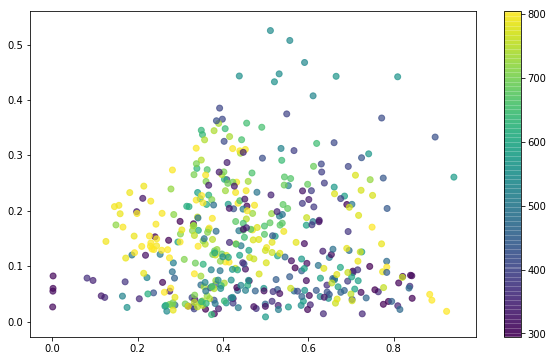

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
im = ax.scatter(tbl_ssam['ellip'], tbl_ssam['lambda_r'], c=tbl_ssam['r'], alpha=0.7)
fig.colorbar(im)

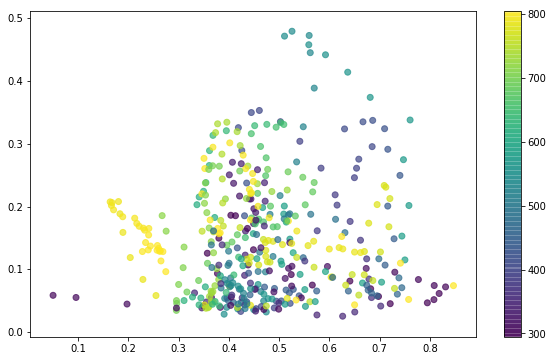

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
im = ax.scatter(tbl_ssam['ellip_mean'], tbl_ssam['lambda_r_mean'], c=tbl_ssam['r'], alpha=0.7)
fig.colorbar(im)

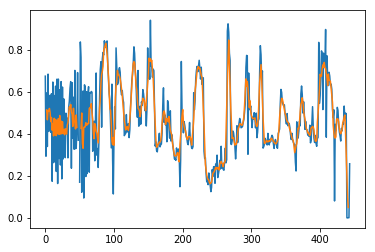

In [14]:
plt.plot(df.ellip)
plt.plot(df.ellip_mean)

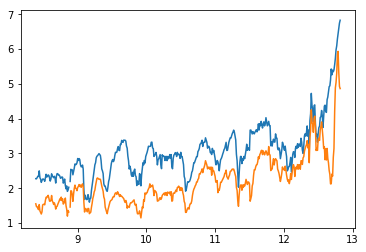

In [15]:
fig, ax = plt.subplots()
ax.plot(tbl_ssam['time'], tbl_ssam['r_eff_kpc3d'])
ax.plot(tbl_ssam['time'], tbl_ssam['r_eff_kpc']);

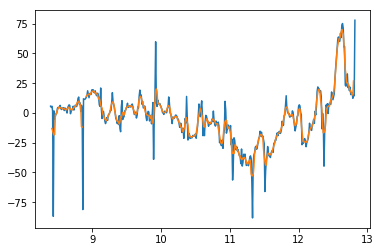

In [16]:
plt.plot(tbl_ssam['time'], df.phases*180/np.pi)
plt.plot(tbl_ssam['time'], df.theta_mean*180/np.pi)

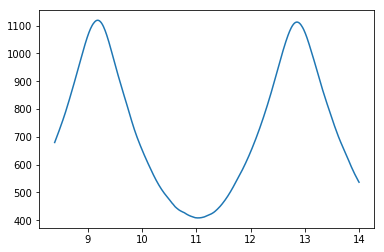

In [17]:
plt.plot(tbl_ssam['time'], tbl_ssam['v'])

In [18]:
from simulation.luminosity import pix2kpc

In [19]:
width=10
resolution=200
a_min=10
n_annuli=30
pix = np.linspace(a_min, int(resolution*1.3), n_annuli)
pix

array([ 10.        ,  18.62068966,  27.24137931,  35.86206897,
        44.48275862,  53.10344828,  61.72413793,  70.34482759,
        78.96551724,  87.5862069 ,  96.20689655, 104.82758621,
       113.44827586, 122.06896552, 130.68965517, 139.31034483,
       147.93103448, 156.55172414, 165.17241379, 173.79310345,
       182.4137931 , 191.03448276, 199.65517241, 208.27586207,
       216.89655172, 225.51724138, 234.13793103, 242.75862069,
       251.37931034, 260.        ])

In [20]:
kpc = pix2kpc(pix, width, resolution)
kpc

array([ 0.5       ,  0.93103448,  1.36206897,  1.79310345,  2.22413793,
        2.65517241,  3.0862069 ,  3.51724138,  3.94827586,  4.37931034,
        4.81034483,  5.24137931,  5.67241379,  6.10344828,  6.53448276,
        6.96551724,  7.39655172,  7.82758621,  8.25862069,  8.68965517,
        9.12068966,  9.55172414,  9.98275862, 10.4137931 , 10.84482759,
       11.27586207, 11.70689655, 12.13793103, 12.56896552, 13.        ])

Text(0, 0.5, '$\\lambda_R$')

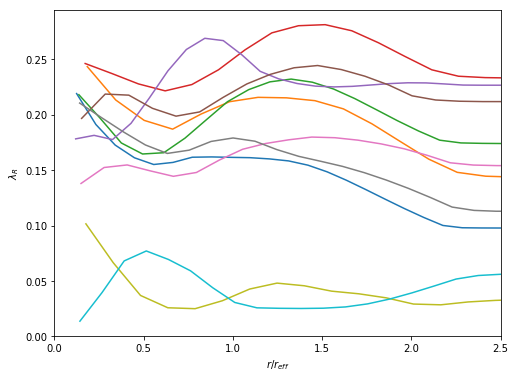

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
slices = slice(None, 10, None)
for i, prof in enumerate(lambda_prof[slices]):
    ax.plot(kpc*np.sqrt(1-tbl_ssam['ellip'][slices][i])/tbl_ssam['r_eff_kpc3d'][slices][i], lambda_prof[slices][i])
ax.set_xlim(0, 2.5)
ax.set_xlabel('$r/r_{eff}$')
ax.set_ylabel('$\lambda_R$')

In [22]:
lp = pd.DataFrame(lambda_prof.data.byteswap().newbyteorder(), columns=range(lambda_prof.shape[1]))

In [23]:
lp_mean10 = lp.rolling(5, center=True, axis=0).mean()

Remember that as per SAURON Paper IX, $\lambda_R = \lambda(R_m)$ where $R_m$ is the mean radius ($R_m = a \sqrt{1-\varepsilon}$) of the photometric best-fitting ellipses, the area $A_{ell}$ of the corresponding aperture being thus $\pi R_m^2$

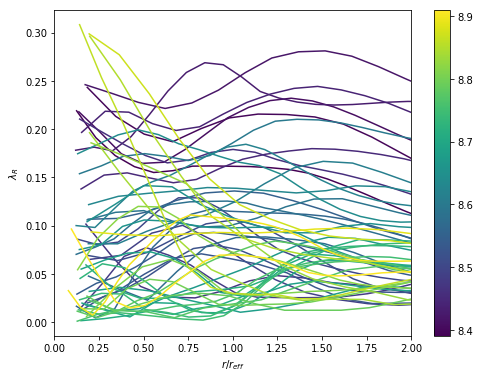

In [49]:
start = 0
N_PROF = 53
step = 1

color_var = 'time'

slices = slice(start, N_PROF, step)

fig, ax = plt.subplots(figsize=(8,6))
value_for_color = tbl_ssam[color_var][slices]
mappable = plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=np.nanmin(value_for_color), vmax=np.nanmax(value_for_color)))
for i, prof in enumerate(lambda_prof[slices]):
# for i, prof in enumerate(lp_mean10.values[slices]):
    ellip = tbl_ssam['ellip'][slices][i]
    reff = tbl_ssam['r_eff_kpc3d'][slices][i]
    color = mappable.to_rgba(tbl_ssam[color_var][slices][i])
    ax.plot(kpc*np.sqrt(1-ellip)/reff, prof, color=color)
ax.set_xlim(0, 2)
ax.set_xlabel('$r/r_{eff}$')
ax.set_ylabel('$\lambda_R$')
mappable.set_array([])
fig.colorbar(mappable)

In [25]:
kpc*np.sqrt(1-ellip)/reff, prof

(array([0.09606817, 0.17888555, 0.26170293, 0.34452032, 0.4273377 ,
        0.51015508, 0.59297247, 0.67578985, 0.75860723, 0.84142462,
        0.924242  , 1.00705939, 1.08987677, 1.17269415, 1.25551154,
        1.33832892, 1.4211463 , 1.50396369, 1.58678107, 1.66959846,
        1.75241584, 1.83523322, 1.91805061, 2.00086799, 2.08368537,
        2.16650276, 2.24932014, 2.33213753, 2.41495491, 2.49777229]),
 array([0.09641149, 0.06922373, 0.0442644 , 0.02090125, 0.01459448,
        0.01732207, 0.0273534 , 0.0402223 , 0.05203158, 0.06301756,
        0.06935427, 0.06956151, 0.06866352, 0.06660885, 0.06296926,
        0.05750664, 0.0514444 , 0.04859586, 0.04783427, 0.04828581,
        0.04939102, 0.05101166, 0.05169866, 0.05223998, 0.05283549,
        0.05328862, 0.05353696, 0.05363386, 0.05365467, 0.05365471]))

## Computing $\lambda$ at r_eff

In [26]:
# ellip = tbl_ssam['ellip']
# reff = tbl_ssam['r_eff_kpc3d']
# x = (kpc*np.ones((563, 30))).T*np.sqrt(1-ellip)/reff
# y = lambda_prof.T
# f = interpolate.interp1d(x, y, axis=1)

In [27]:
lambda_reff_list = list()
for i, prof in enumerate(lambda_prof):
    ellip = tbl_ssam['ellip'][i]
    reff = tbl_ssam['r_eff_kpc3d'][i]
    x = kpc*np.sqrt(1-ellip)/reff
    y = prof
    f = interpolate.interp1d(x, y)
    try:
        lambda_reff_list.append(f(1.0))
    except ValueError as e:
#         print(i, e)
        lambda_reff_list.append(np.nan)
lambda_reff = np.array(lambda_reff_list)

In [28]:
tbl_ssam['lambda_reff'] = lambda_reff

In [29]:
df = tbl_ssam.to_pandas()

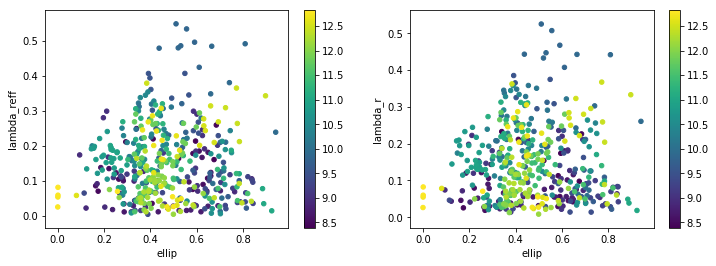

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
df.plot.scatter('ellip', 'lambda_reff', c=df.time, cmap='viridis', ax=ax[0])
# ax[0].set_xlabel('ellip');
df.plot.scatter('ellip', 'lambda_r', c=df.time, cmap='viridis', ax=ax[1])

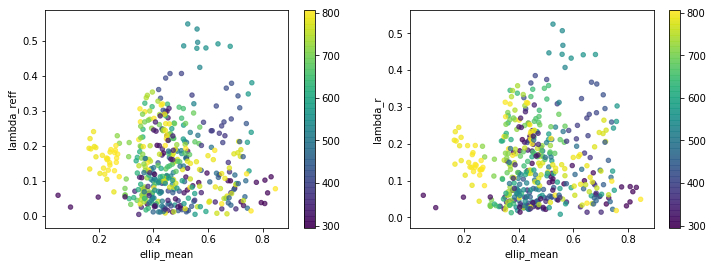

In [35]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
df.plot.scatter('ellip_mean', 'lambda_reff', c=df.r, cmap='viridis', ax=ax[0], alpha=0.7)
df.plot.scatter('ellip_mean', 'lambda_r', c=df.r, cmap='viridis', ax=ax[1], alpha=0.7)

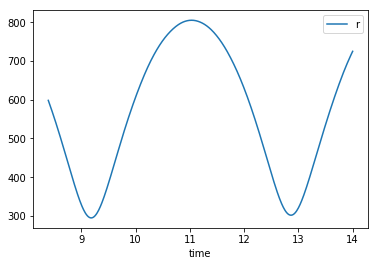

In [36]:
df.plot('time', 'r')

In [37]:
c1 = df.query('time < 10')['r'].idxmin()
c2 = df.query('10 < time < 12')['r'].idxmax()
c3 = df.query('time > 10')['r'].idxmin()
c1, c2,c3

(79, 264, 447)

In [38]:
labels = list(range(1, 5))
labels

[1, 2, 3, 4]

In [39]:
df['group'] = pd.cut(df.index, [0, c1, c2, c3, len(df)], right=False, labels=labels)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 34 columns):
time             563 non-null float64
lambda_r         443 non-null float64
ellip            443 non-null float64
theta            443 non-null float64
r_eff_kpc        443 non-null float64
r_eff_kpc3d      443 non-null float64
n                443 non-null float64
Lx               443 non-null float64
Ly               443 non-null float64
Lz               443 non-null float64
mag_v            443 non-null float64
r                563 non-null float64
v                563 non-null float64
a                563 non-null float64
x                563 non-null float64
y                563 non-null float64
z                563 non-null float64
vx               563 non-null float64
vy               563 non-null float64
vz               563 non-null float64
ax               563 non-null float64
ay               563 non-null float64
az               563 non-null float64
mass_star        563 

In [41]:
first_infall = df[df['group']==1]
first_splashback = df[df['group']==2][::2]
second_infall = df[df['group']==3][::2]
second_splashback = df[df['group']==4]
second_infall.head()

,time,lambda_r,ellip,theta,r_eff_kpc,r_eff_kpc3d,n,Lx,Ly,Lz,...,sigma_gas,sigma_star,sfr,metals_star,lambda_r_mean,ellip_mean,phases,theta_mean,lambda_reff,group
264,11.029997,0.060180,0.277263,2.758261,2.220897,2.798758,0.570347,-3.359993,4.088380,6.089551,...,11.886733,17.806358,0.005705,2.370544e-12,0.051205,0.533939,-0.383332,-0.554474,0.082574,3
266,11.049999,0.018337,0.924013,2.396778,1.967664,2.677956,0.495226,-3.809693,3.858318,5.785508,...,12.338470,17.146992,0.001164,2.369488e-12,0.052089,0.757751,-0.744815,-0.579883,0.015181,3
268,11.069991,0.098343,0.783761,2.744291,2.040473,2.683816,0.834123,-4.470369,3.803823,4.839623,...,12.779793,16.674366,0.019993,2.370933e-12,0.109861,0.741470,-0.397302,-0.506661,0.120964,3
270,11.089994,0.214268,0.352958,2.602762,2.172991,2.854420,0.498841,-4.958119,3.694653,3.941106,...,14.057202,16.456890,0.026926,2.371345e-12,0.176970,0.518635,-0.538830,-0.499729,0.192874,3
272,11.109996,0.168669,0.367332,2.583654,2.251829,2.980051,0.529157,-5.590659,3.241409,4.141813,...,15.865568,16.520620,0.031389,2.373001e-12,0.165121,0.377884,-0.557939,-0.544700,0.152538,3


In [42]:
len(first_infall), len(first_splashback), len(second_infall), len(second_splashback)

(79, 93, 92, 116)

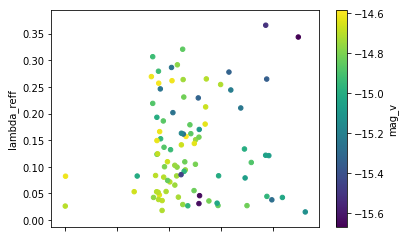

In [43]:
second_infall.plot.scatter('ellip', 'lambda_reff', c='mag_v', cmap='viridis')

In [44]:
colors = {1:'red', 2:'blue', 3:'green', 4:'black'}
label = {1:'1st infall', 2:'1st splback', 3:'2nd infall', 4:'2nd splback'}

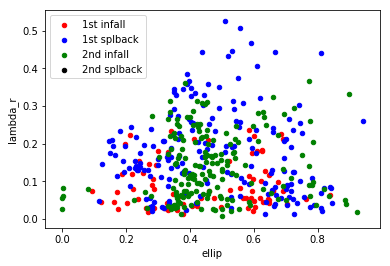

In [45]:
fig, ax = plt.subplots()
for k in colors.keys():
    df[df['group']==k].plot.scatter('ellip', 'lambda_r', ax=ax, color=colors[k], label=label[k])

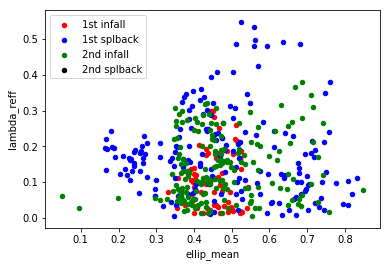

In [46]:
# df.plot.scatter('ellip_mean', 'lambda_r', c=df['group'].map(colors))
fig, ax = plt.subplots()
for k in colors.keys():
    df[df['group']==k].plot.scatter('ellip_mean', 'lambda_reff', ax=ax, color=colors[k], label=label[k])

---

SAURON Emsellem 2007

![SAURON Emsellem 2007](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/mnras/379/2/10.1111/j.1365-2966.2007.11752.x/2/mnras0379-0401-f2.jpeg?Expires=1550241570&Signature=WJYq2HjGik4c~q5AQtjClAoaR76uexBGueQqhpFxmenAdsuEuxjjhEUEGKwOM68DLKfdlyQtHmOgKJ8oBo~bXQB7dpDn5LFnrXTQw9uiRKo0eRgidXTxwLUNk0zzhIk5u05vQ502LnIJf~G0QJf6Yv7xffJyma8EKO0HG2wbXa0fGwbQNLsDW-AInNej2p0YaSXkJEg-QEJw2KvAsKs~Sd4lVryKqmLFAJ1LMX4kAPyoDCg-TIQjuRXapDEi2CORgXBT1S~yUbGiiIIZX6wwvyhCbN~jFMOPT8KuvVtJUGJzjhz9IPms8ma2EVwfJzb4Fl3KUt2BZc94GgtyApit0g__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)

----

Naab 2014 (http://doi.org/10.1093/mnras/stt1919)

In [63]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/mnras/444/4/10.1093/mnras/stt1919/3/stt1919fig5.png?Expires=1550241649&Signature=mTMFGy1NapHMRDue3Qwdrw4sToEAFw7UKKfTrMQ0EbArhDAM0ai2WIUCwaN5NRQ3OMHxpkai2FmaNYaH7qoubZaSQUUcyWXQNnPlfHppfKwyqcLtLulOadvwp6NTpCq4ei67j1-88Fyz5M7FMkXBGFJ3Hn2tkeEYexppZILW5gleE2a7PP8yMp6LBenvQsKahTyaCAWzozWXc~XPuoF5H3qlyLjgUMCrPO5hVzQpOAWsBadhr4J1jMsk25HuxZswM~ONmfUhbG9FDNUU1Lo0QFnevDiwn9oymhyTETnOHMlXrdaqPcKoMcMloKTTzqEQOEcENJcqheoGfAQWe58vcQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA",
      width=400)

In [62]:
# HTML(url='https://academic.oup.com/view-large/figure/33260291/stt1919fig5.tiff')